<a href="https://colab.research.google.com/github/newh08/AI_Voyage/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [MYCODE] 데이터를 CIFAR10 으로 변경하기

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

Files already downloaded and verified


## [LOG] CIFAR10 데이터 출력해보기

50000
torch.Size([3, 32, 32])


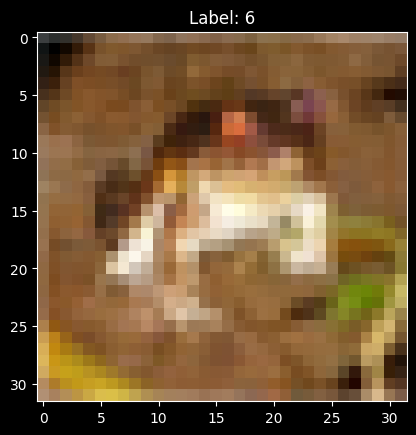

In [ ]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape)
# CIFAR-10 이미지 출력
# torch.Tensor는 (체널, 높이, 너비) 순서 에서 matplotlib 에서 쓰이는 (높이, 너비, 채널) 로 변경
plt.imshow(trainset[0][0].permute(1, 2, 0))
plt.title(f"Label: {trainset[0][1]}")
plt.show()

## [LOG] 배치 생성후 출력해 입력을 어떻게 할지 확인해보기

In [ ]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


## [MYCODE] 테스트용 데이터 및 배치 생성하기

In [ ]:
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


## [MYCODE] 모델 정의 및 평가 함수, 시각화 함수 정의하기

In [ ]:
from torch import nn


# 모델 정의 활성함수를 파라미터로 넣을수 있도록 설계
class Model(nn.Module):
    def __init__(self, input_dim, n_dim, active_function):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.act = active_function

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)

        return x


criterion = nn.CrossEntropyLoss()
lr = 0.001
n_epochs = 50

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


class AccuracyMonitor:
    def __init__(
        self, models, dataloaders, labels, title="Model Accuracies", accuracy_fn=None
    ):
        """
        models: 모델 리스트
        dataloaders: 데이터로더 리스트
        labels: 모델 및 데이터로더에 대한 레이블 리스트
        title: 그래프 제목
        accuracy_fn: 사용자 정의 정확도 함수 (default_accuracy를 기본값으로 사용)
        """
        if not (len(models) == len(dataloaders) == len(labels)):
            raise ValueError(
                "models, dataloaders, labels는 모두 같은 길이를 가져야 합니다."
            )

        self.models = models
        self.dataloaders = dataloaders
        self.labels = labels
        self.title = title
        self.acc_lists = [[] for _ in labels]
        self.accuracy_fn = accuracy_fn if accuracy_fn else self.default_accuracy

    def default_accuracy(self, model, dataloader):
        """
        기본 정확도 계산 함수.
        """
        cnt = 0
        acc = 0

        for data in dataloader:
            inputs, labels = data

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

        return acc / cnt

    def update_accuracies(self, verbose=False):
        """
        models와 dataloaders를 평가하고 acc_lists에 기록.
        verbose: True인 경우 정확도 업데이트 로그 출력.
        """
        for i, (model, dataloader) in enumerate(zip(self.models, self.dataloaders)):
            acc = self.accuracy_fn(model, dataloader)
            self.acc_lists[i].append(acc)
            if verbose:
                print(f"Updated Accuracy ({self.labels[i]}): {acc:.4f}")

    def plot(self, epoch=None, save_path=None):
        """
        정확도 그래프를 출력하고 저장하는 기능.
        epoch: 그래프 제목에 표시할 에폭 정보
        save_path: 그래프를 저장할 경로 (None이면 저장하지 않음)
        """
        if not self.acc_lists or len(self.acc_lists[0]) == 0:
            print("No accuracies to plot")
            return

        x = np.arange(len(self.acc_lists[0]))  # 에폭 수만큼 x축 생성

        plt.figure(figsize=(10, 6))  # 그래프 크기 조정
        for acc_list, label in zip(self.acc_lists, self.labels):
            plt.plot(x, acc_list, label=label, marker="o")

        title = f"{self.title} at Epoch {epoch}" if epoch is not None else self.title
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        plt.ylim(0.0, 1.0)

        if save_path:
            plt.savefig(save_path)
            print(f"Plot saved to {save_path}")
        else:
            plt.show()

## [LOG] Plot 1. 최적화 함수 비교, SGD 와 Adam 학습 후 정확도 출력하기

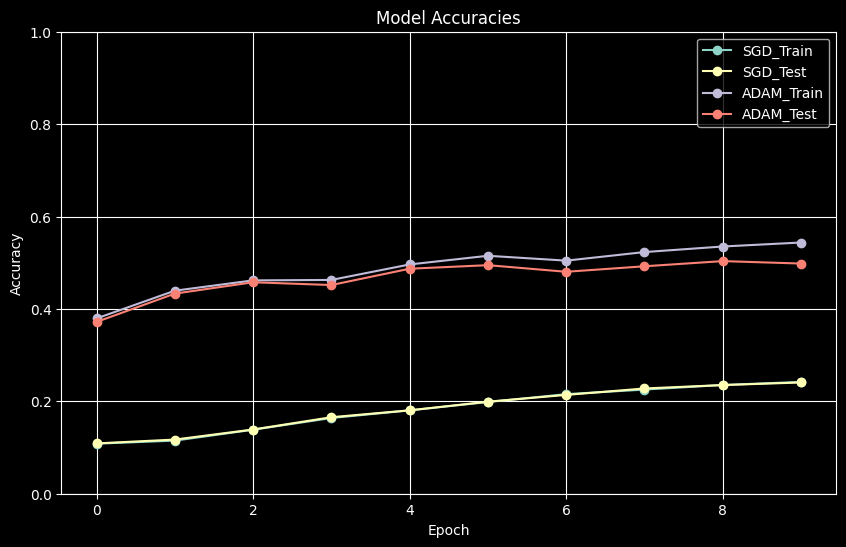

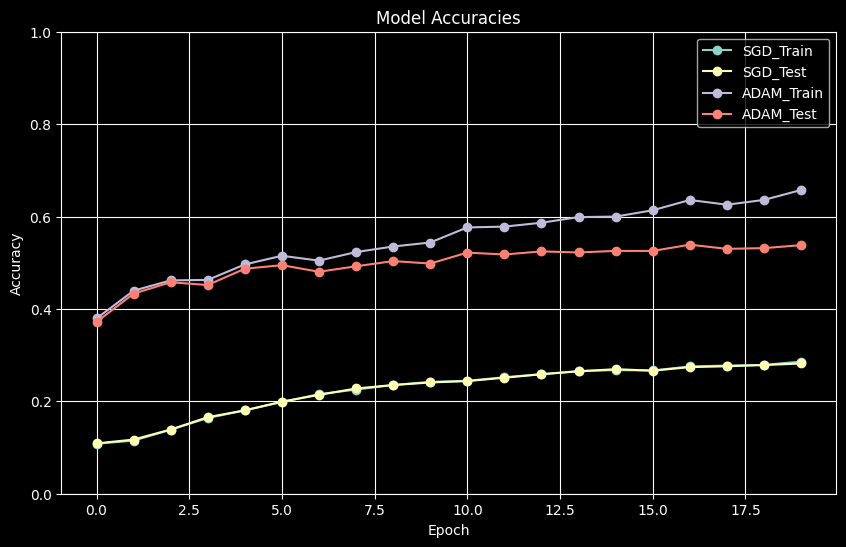

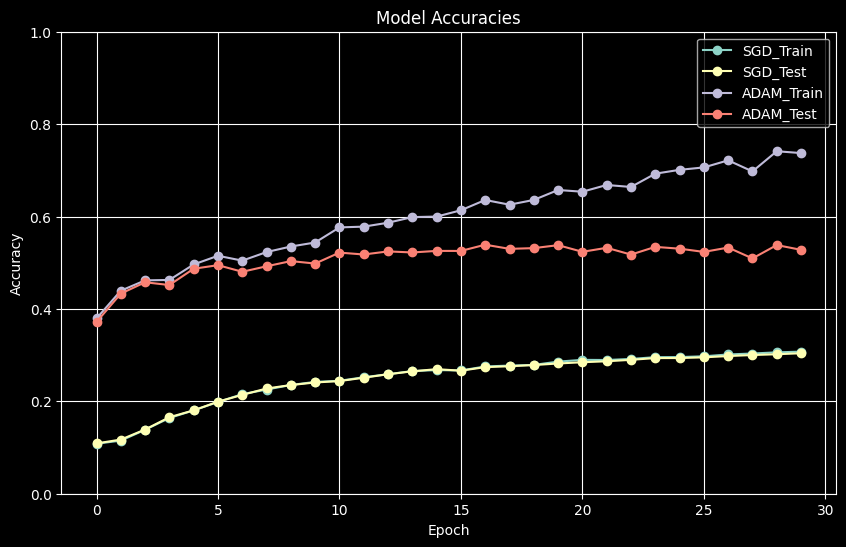

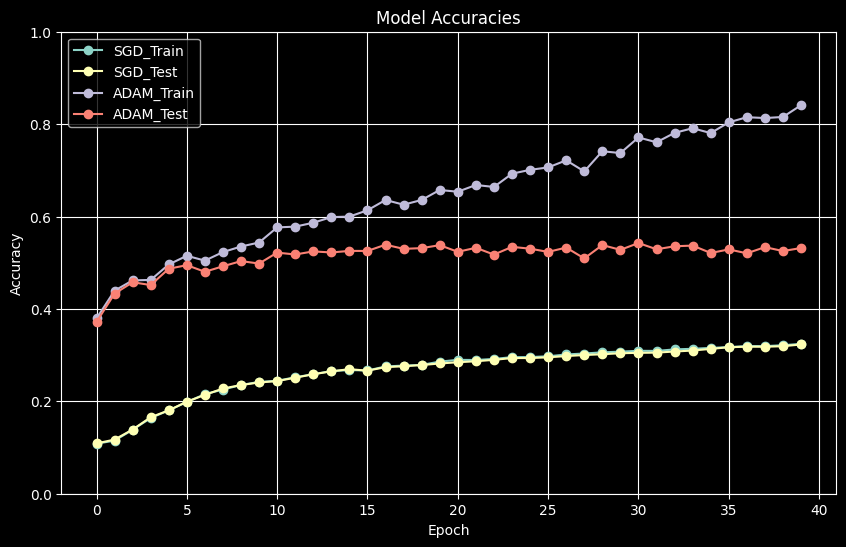

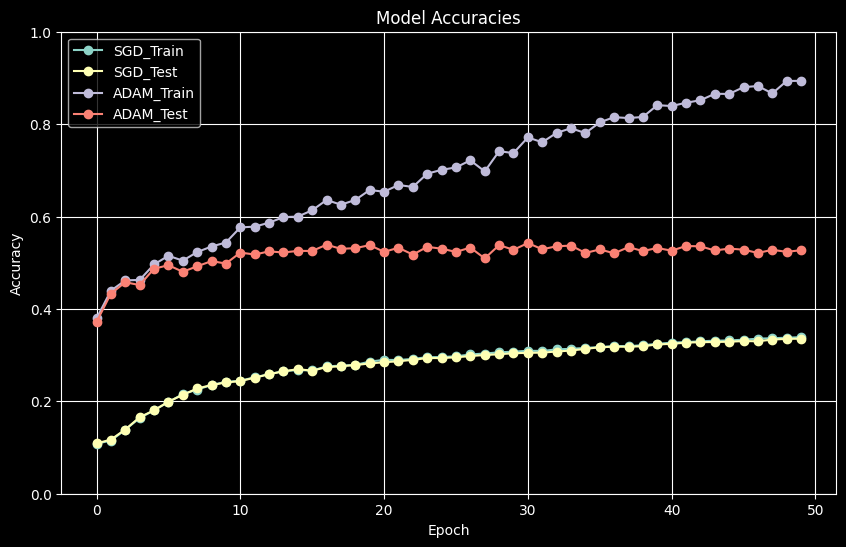

In [ ]:
from torch.optim import SGD, Adam

# 모델 구현
leaky_relu_model_sgd = Model(32 * 32 * 3, 1024, nn.LeakyReLU())
leaky_relu_model_adam = Model(32 * 32 * 3, 1024, nn.LeakyReLU())

# 최적화 함수 정의

sgd_optimizer = SGD(leaky_relu_model_sgd.parameters(), lr=lr)
adam_optimizer = Adam(leaky_relu_model_adam.parameters(), lr=lr)


monitor = AccuracyMonitor(
    models=[
        leaky_relu_model_sgd,
        leaky_relu_model_sgd,
        leaky_relu_model_adam,
        leaky_relu_model_adam,
    ],
    dataloaders=[trainloader, testloader, trainloader, testloader],
    labels=["SGD_Train", "SGD_Test", "ADAM_Train", "ADAM_Test"],
)


for epoch in range(n_epochs):

    for data in trainloader:

        inputs, labels = data
        sgd_optimizer.zero_grad()

        sgd_preds = leaky_relu_model_sgd(inputs)
        sgd_loss = criterion(sgd_preds, labels)
        sgd_loss.backward()
        sgd_optimizer.step()

        adam_optimizer.zero_grad()

        adam_prds = leaky_relu_model_adam(inputs)
        adam_loss = criterion(adam_prds, labels)
        adam_loss.backward()
        adam_optimizer.step()

    monitor.update_accuracies()

    if (epoch + 1) % 10 == 0:  # 10 epoch마다 그래프 업데이트
        monitor.plot()

##[FEEDBACK] CrossEntropyLoss 손실함수에 넣어주는 값이 10차원 텐서인 출력값과 라벨인 숫자1자리 일 것같은데, 이 둘 사이의 맵핑이 어떻게 이루어지나요? 단순히 6 이면 텐서에서 6번째 숫자 로 맵핑일까요?

##[FEEDBACK] ADAM 에서 학습이 진행되어도 성공률이 진동하는 이유..?

##[FEEDBACK] lr 을 조절하니 SGD 에서 학습진행 대비 성공률이 크게 달라지는걸 로그로 확인해봤습니다. 여기서 lr 조절의 의미는 최적화 함수에서 파라미터를 변화시키는 크기를 조절한다고 이해해도 괜찮을까요?

## [LOG] Plot 2. 활성화 함수 비교, sigmoid 와 leaky ReLU 비교하기

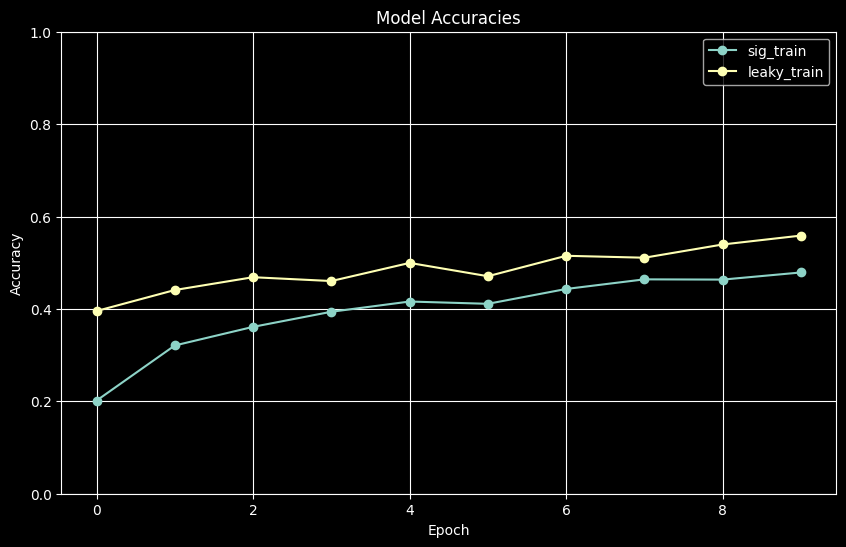

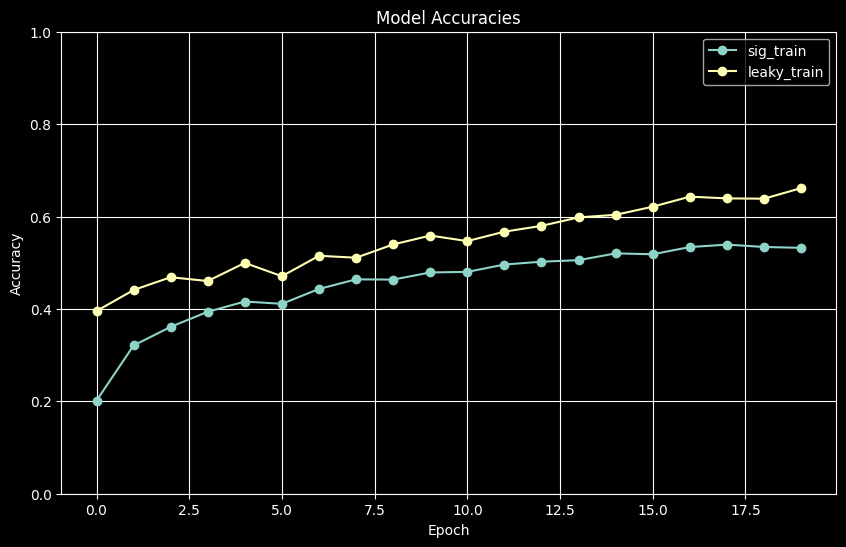

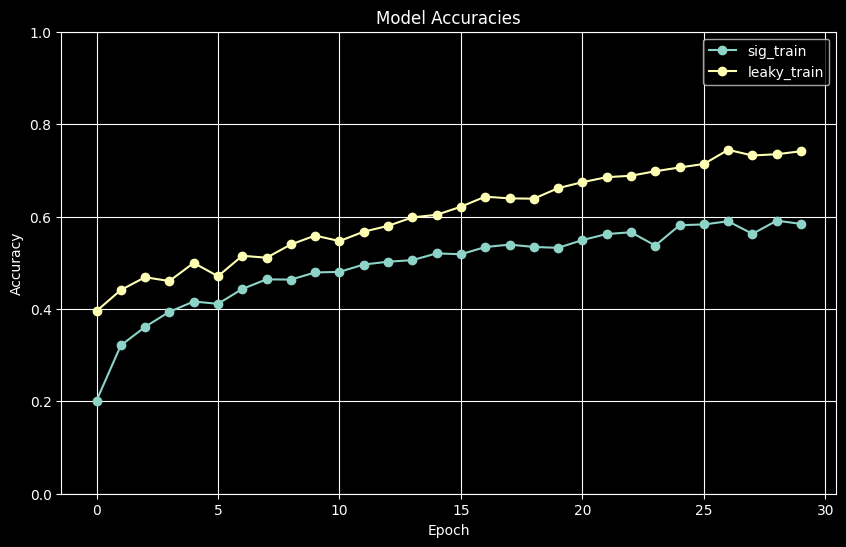

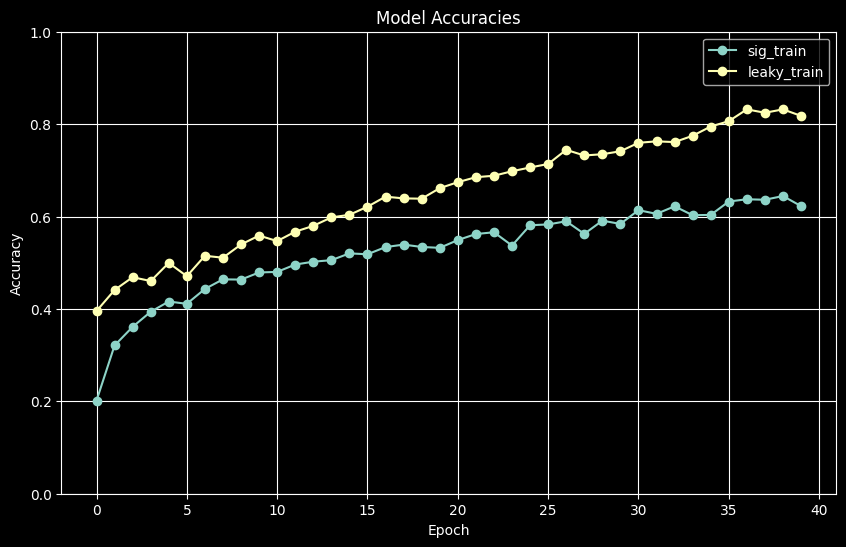

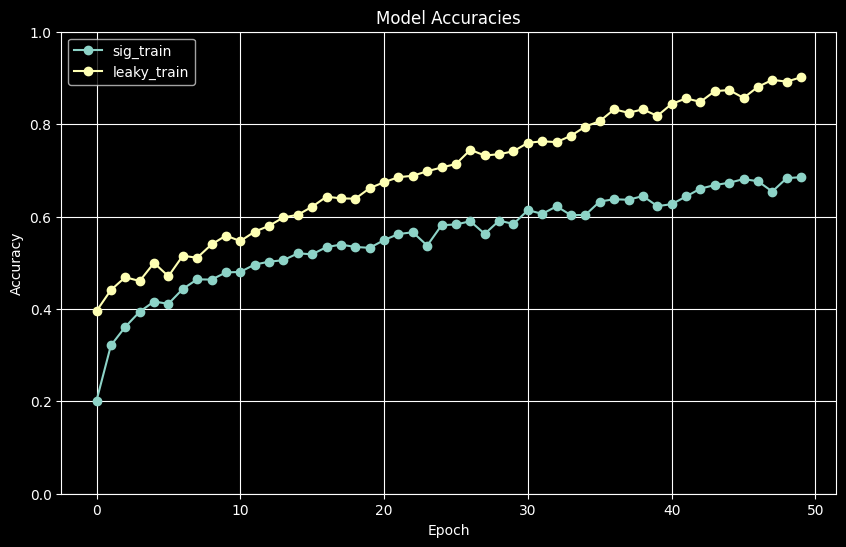

In [ ]:
sigmoid_model_adam = Model(32 * 32 * 3, 1024, nn.Sigmoid())
leaky_relu_model_adam_2 = Model(32 * 32 * 3, 1024, nn.LeakyReLU())

sig_adam_optimizer = Adam(sigmoid_model_adam.parameters(), lr=lr)
relu_adam_optimizer = Adam(leaky_relu_model_adam_2.parameters(), lr=lr)

plot2_monitor = AccuracyMonitor(
    models=[sigmoid_model_adam, leaky_relu_model_adam_2],
    dataloaders=[trainloader, trainloader],
    labels=["sig_train", "leaky_train"],
)

bce_loss = nn.BCELoss()

for epoch in range(n_epochs):

    for data in trainloader:

        inputs, labels = data

        sig_adam_optimizer.zero_grad()

        sig_preds = sigmoid_model_adam(inputs)
        labels_onehot = torch.nn.functional.one_hot(
            labels, num_classes=10
        ).float()  # BCELoss 손실함수가 계산할 수 있도록 라벨 원핫 인코딩
        sig_loss = bce_loss(torch.sigmoid(sig_preds), labels_onehot)

        sig_loss.backward()
        sig_adam_optimizer.step()

        relu_adam_optimizer.zero_grad()

        relu_prds = leaky_relu_model_adam_2(inputs)
        relu_loss = criterion(relu_prds, labels)
        relu_loss.backward()
        relu_adam_optimizer.step()

    plot2_monitor.update_accuracies()

    if (epoch + 1) % 10 == 0:  # 10 epoch마다 그래프 업데이트
        plot2_monitor.plot()

## [LOG] Plot3. Dropout 적용해 train 과 test 정확도 비교하기

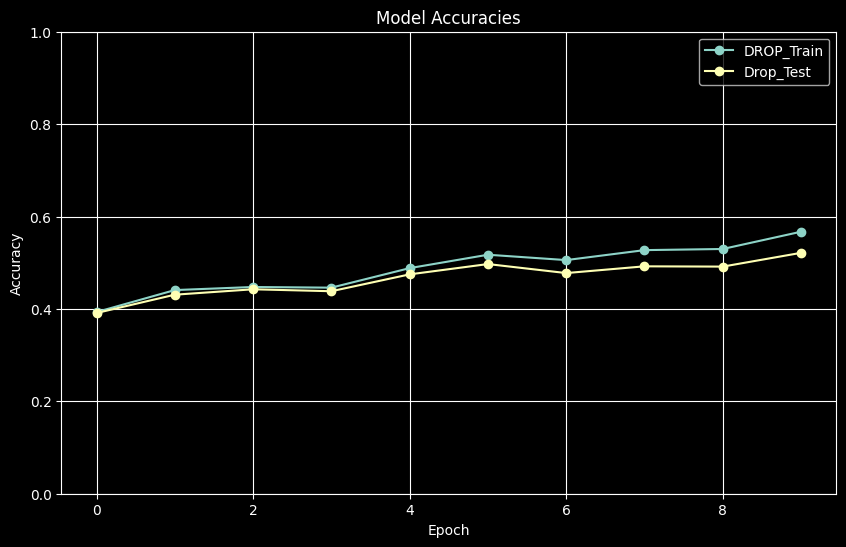

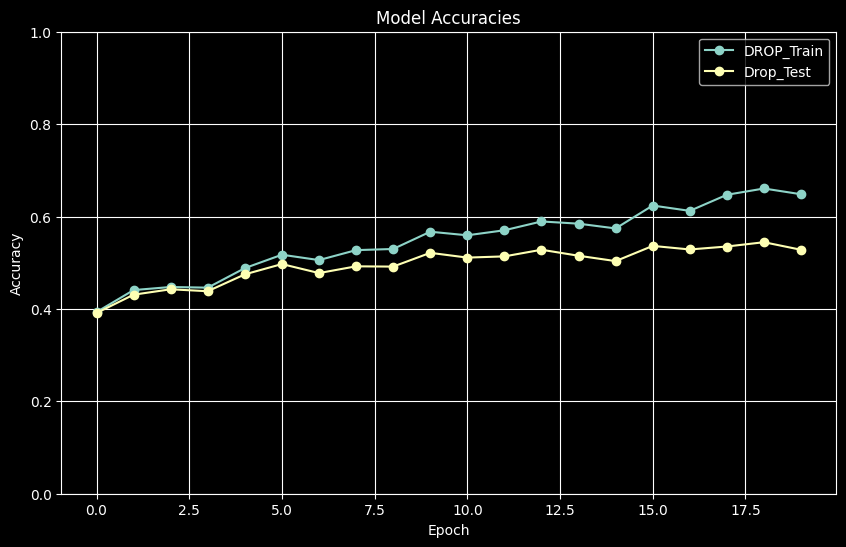

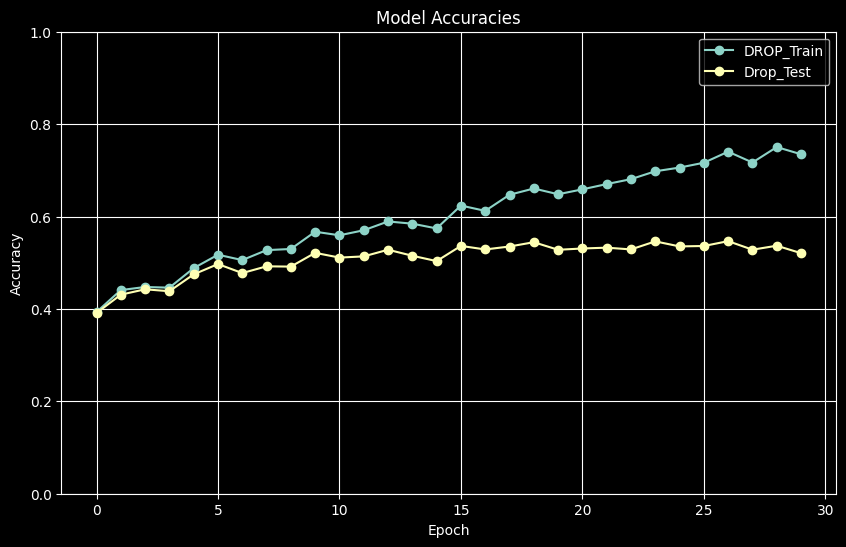

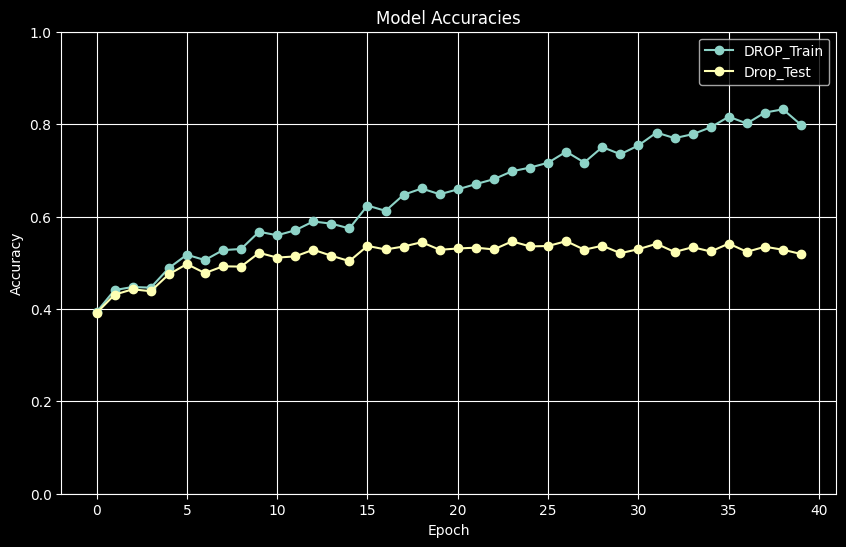

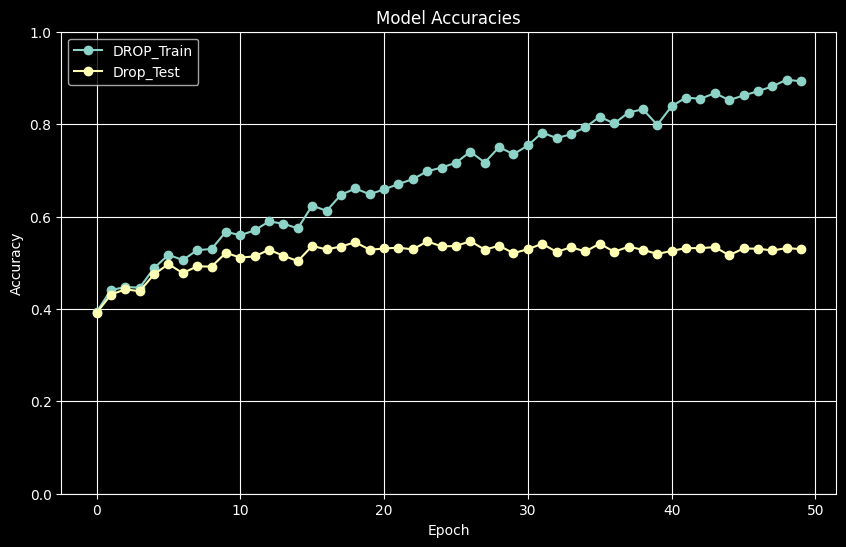

In [ ]:
class DropoutModel(nn.Module):
    def __init__(self, input_dim, n_dim, active_function, dropout_prob=0.1):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.layer2 = nn.Linear(n_dim, n_dim)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.layer3 = nn.Linear(n_dim, 10)
        self.act = active_function

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.dropout1(x)

        x = self.act(self.layer2(x))
        x = self.dropout2(x)
        x = self.layer3(x)

        return x


def custom_accuracy(model, dataloader):

    cnt = 0
    acc = 0
    model.eval()

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)
            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()
    model.train()
    return acc / cnt


dropout_model_relu = Model(32 * 32 * 3, 1024, nn.LeakyReLU())

relu_adam_dropout_optimizer = Adam(dropout_model_relu.parameters(), lr=lr)

drop_monitor = AccuracyMonitor(
    models=[dropout_model_relu, dropout_model_relu],
    dataloaders=[trainloader, testloader],
    labels=["DROP_Train", "Drop_Test"],
    accuracy_fn=custom_accuracy,
)

for epoch in range(n_epochs):
    dropout_model_relu.train()
    for data in trainloader:

        inputs, labels = data
        relu_adam_dropout_optimizer.zero_grad()

        drop_preds = dropout_model_relu(inputs)
        drop_loss = criterion(drop_preds, labels)
        drop_loss.backward()
        relu_adam_dropout_optimizer.step()

    drop_monitor.update_accuracies()

    if (epoch + 1) % 10 == 0:  # 10 epoch마다 그래프 업데이트
        drop_monitor.plot()